<a href="https://colab.research.google.com/github/chase-capron/ImageProcessing/blob/master/Counting_Coins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [430]:
# Importing necessary Image Processing libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline

# Uploading File to Colab notebook
from google.colab import files
uploaded = files.upload()

# Used to verify if file has been uploaded
for file in uploaded.keys():
  print('Uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

Saving Test1.png to Test1.png
Uploaded file "Test1.png" with length 499128 bytes


In [0]:
# Function used to display image onto screen
def display(im, title=None, **kwargs):
    kwargs['cmap'] = 'gray'
    plt.figure() # Creates a seperate window for viewing an Image
    plt.imshow(im, **kwargs) # Displays the image using cmap arguments
    plt.title(title)
    plt.axis('off') # Turns off the plot axis's to just display the Image
    return im

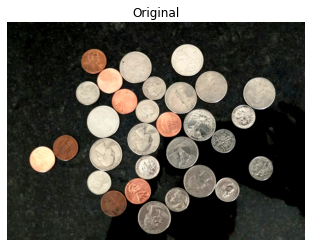

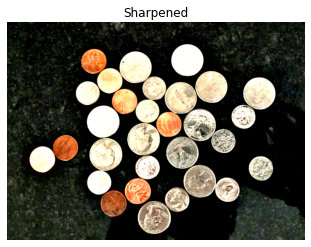

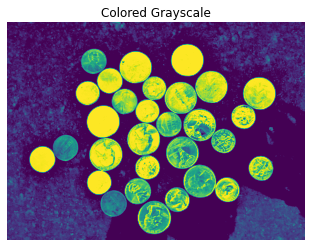

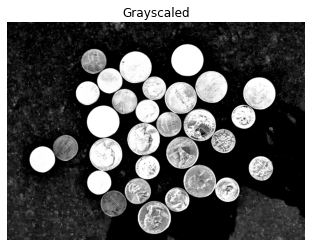

In [432]:
# Reads in the Image file to an array my_image
# To use another Image, upload multiple images and replace the file name in my_image
my_image = plt.imread('Test1.png') # [Insert file name here]

# Mask to Sharpen the Image for pre-processing (Helps distinquish coins from background)
from skimage.filters import unsharp_mask
rad = 20.0 # Change this to adjust Sharpening intensity
sharp_im = unsharp_mask(my_image, radius = rad) # New Sharpened Image

# Displaying Original and new Sharpened Image
display(my_image, 'Original', cmap=None) # Display uploaded Image
display(sharp_im, 'Sharpened', cmap=None) # Display Sharpened Image

# Creating Colored Grayscale
heat = color.rgb2gray(sharp_im) # Defaults to Grayscaling the image as a colored Heatmap just for reference
plt.figure()
plt.imshow(heat)
plt.title('Colored Grayscale')
plt.axis('off')

# Creating True Grayscale with Color Map
gray = display(heat, 'Grayscaled') # No cmap argument defaults to cmap='gray'

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

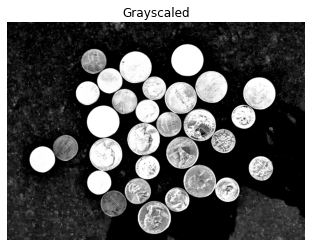

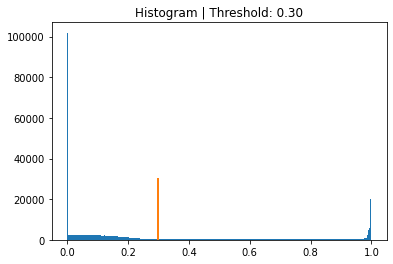

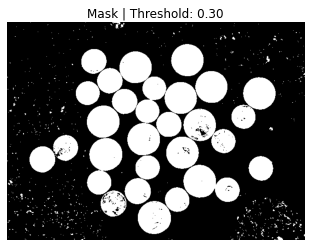

In [433]:
# Creating a Thresholding Mask
from skimage.filters import threshold_otsu

# Using a Otsu method Thresholder from skimage library
gray = display(heat, 'Grayscaled')
thresh = threshold_otsu(gray, nbins=5) # Determines the Threshold value for the border of coins, 5 bins optimizes the coin images the best
binary = gray > thresh  # New Binary mask

plt.figure()
plt.hist(gray.ravel(), bins=250); # Displays Histogram of Gray values in Image
plt.title('Histogram | Threshold: %.2f' % thresh) # Sets threshold to 2 decimal places
plt.plot([thresh, thresh], [0,30000], linewidth=2)

display(binary, 'Mask | Threshold: %.2f' % thresh) # Displays the new Binary Image

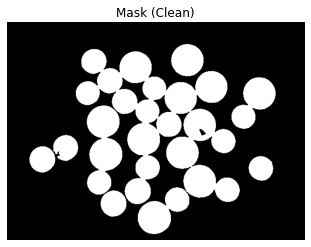

In [437]:
# Cleaning up the Mask for final processing
from skimage.morphology import disk

no_holes = morphology.remove_small_objects(binary, min_size=150) # Removes objects smaller than 150 pixels

disks = morphology.binary_closing(no_holes, disk(1)) # Removes small background noise by performing a dilation followed by an erosion

mask_filter = ~morphology.remove_small_objects(~disks) # Removes black noise from the inverse color of 'disks' and then reverts image back


mask = display(mask_filter, 'Mask (Clean)')

(-0.5, 648.5, 474.5, -0.5)

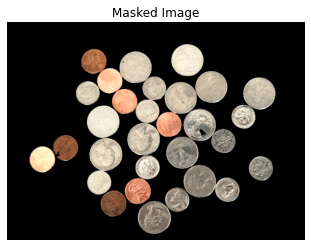

In [435]:
# Applies the Mask to the Original Image of the coins
my_image[~mask] = 0 # Applies black mask to image
plt.imshow(my_image)
plt.title('Masked Image')
plt.axis('off')

Number of coins: 30


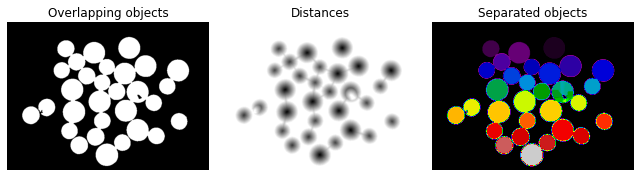

In [436]:
# Detecting Objects in Image by Watershed Segmentation
'''This section is referenced from watershed documentation by scikit at
 https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html'''

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops

distance = ndi.distance_transform_edt(mask) # Calculating the exact euclidean transform to detect nearest background color (edge)
local_max = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask) # Stores the calculated maximum distances
markers = ndi.label(local_max)[0] # Sets the center of the circle based on local_max
labels = watershed(-distance, markers, mask=mask) # Performs Watershed Segmentation on center markers

# Detect Objects of specified Size
regions = regionprops(labels) # Measures properties of the objects detected
regions = [r for r in regions if r.area > 600] # If the area of the object is greater than 600 pixels, count it
print('Number of coins:', len(regions) - 1) # Prints the amount of regions detected minus the background region 

# Configuring the code to display images as one
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel() # Flattens the image to 1-D array

# Displaying Image arrays in subplots
ax[0].imshow(mask, cmap='gray')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap='gray')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap='nipy_spectral')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()